# **Klasifikasi Obesitas Menggunakan SVM dan XGBoost**

In [16]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import pickle
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## **1. Data Loading dan Pemahaman Data**


In [17]:
# Load dataset
df = pd.read_csv('ObesityDataSet2.csv')

# Tampilkan informasi dasar dataset
print("=" * 50)
print("INFORMASI DATASET")
print("=" * 50)
print(f"Shape dataset: {df.shape}")
print(f"Jumlah fitur: {df.shape[1]-1}")
print(f"Jumlah target: {df.shape[0]}")

print("\n" + "=" * 50)
print("INFO DATASET")
print("=" * 50)
print(df.info())

print("\n" + "=" * 50)
print("PREVIEW DATA")
print("=" * 50)
print(df.head(10))


INFORMASI DATASET
Shape dataset: (1056, 17)
Jumlah fitur: 16
Jumlah target: 1056

INFO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1056 non-null   object 
 1   Age                             1056 non-null   object 
 2   Height                          1056 non-null   float64
 3   Weight                          1056 non-null   float64
 4   family_history_with_overweight  1056 non-null   object 
 5   FAVC                            1056 non-null   object 
 6   FCVC                            1019 non-null   float64
 7   NCP                             1056 non-null   float64
 8   CAEC                            1056 non-null   object 
 9   SMOKE                           1056 non-null   object 
 10  CH2O                            1056 non-null   float64
 11  

DISTRIBUSI TARGET VARIABLE (NObeyesdad)
NObeyesdad
Obesity_Type_I         176
Obesity_Type_III       162
Obesity_Type_II        149
Overweight_Level_II    145
Overweight_Level_I     145
Normal_Weight          143
Insufficient_Weight    136
Name: count, dtype: int64


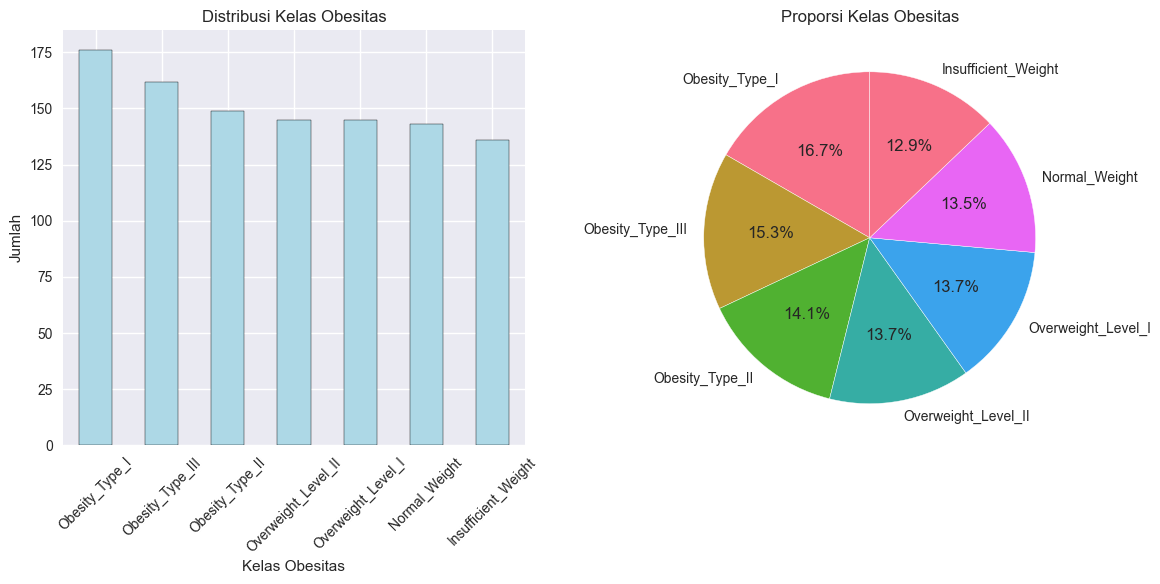

In [43]:
# Analisis target variable
print("=" * 50)
print("DISTRIBUSI TARGET VARIABLE (NObeyesdad)")
print("=" * 50)
print(df['NObeyesdad'].value_counts())

# Visualisasi distribusi target
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['NObeyesdad'].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Distribusi Kelas Obesitas')
plt.xlabel('Kelas Obesitas')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['NObeyesdad'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Kelas Obesitas')
plt.ylabel('')

plt.tight_layout()
plt.show()


## **2. Data Cleaning dan Preprocessing**


In [20]:
# Identifikasi dan handling missing values
print("=" * 50)
print("MISSING VALUES ANALYSIS")
print("=" * 50)
print("Missing values per kolom:")
missing_vals = df.isnull().sum()
print(missing_vals[missing_vals > 0])

if missing_vals.sum() > 0:
    print(f"\nTotal missing values: {missing_vals.sum()}")
else:
    print("\nTidak ada missing values dalam dataset")

# Cek nilai kosong atau string kosong
print("\n" + "=" * 50)
print("EMPTY STRING ANALYSIS")
print("=" * 50)
for col in df.columns:
    empty_count = (df[col] == '').sum()
    if empty_count > 0:
        print(f"{col}: {empty_count} empty strings")
        
# Deteksi nilai yang tidak standar
print("\n" + "=" * 50)
print("UNIQUE VALUES PER KOLOM")
print("=" * 50)
for col in df.columns:
    print(f"\n{col}: {df[col].nunique()} unique values")
    if df[col].dtype == 'object':
        print(f"Values: {df[col].unique()[:]}")  # Tampilkan 10 pertama saja


MISSING VALUES ANALYSIS
Missing values per kolom:
FCVC      37
MTRANS    26
dtype: int64

Total missing values: 63

EMPTY STRING ANALYSIS

UNIQUE VALUES PER KOLOM

Gender: 2 unique values
Values: ['Female' 'Male']

Age: 46 unique values
Values: ['24' '23' '21' '22' '26' '18' '25' '20' '32' '20 years' '19' '38' '34'
 '44' '39' '22 years' '41' '31' '17 years' '17' '29' '42' '27' '16'
 '25 years' '40' '21 years' '33' '30' '37' '35' '36' '15' '19 years' '28'
 '55' '46' '36 years' '26 years' '45' '33 years' '43' '51' '48' '23 years'
 '14']

Height: 47 unique values

Weight: 715 unique values

family_history_with_overweight: 2 unique values
Values: ['yes' 'no']

FAVC: 2 unique values
Values: ['no' 'yes']

FCVC: 147 unique values

NCP: 194 unique values

CAEC: 4 unique values
Values: ['Sometimes' 'Frequently' 'no' 'Always']

SMOKE: 2 unique values
Values: ['no' 'yes']

CH2O: 186 unique values

SCC: 2 unique values
Values: ['no' 'yes']

FAF: 225 unique values

TUE: 468 unique values

CALC: 4 u

### **Data Cleaning - Handle Age column yang memiliki format berbeda**

In [21]:
print("=" * 50)
print("DATA CLEANING - AGE COLUMN")
print("=" * 50)

# Cek nilai unik di kolom Age
print("Unique values in Age column:")
print(df['Age'].unique())

def clean_age(age):
    """
    Fungsi untuk membersihkan kolom age yang bisa berupa:
    - Angka biasa: 24, 23, dll
    - String dengan 'years': '20 years'
    """
    if pd.isna(age):
        return np.nan
    
    # Jika sudah berupa angka
    if isinstance(age, (int, float)):
        return float(age)
    
    # Jika berupa string, ekstrak angka
    if isinstance(age, str):
        # Cari angka dalam string menggunakan regex
        numbers = re.findall(r'\d+', str(age))
        if numbers:
            return float(numbers[0])
    
    return np.nan

# Apply cleaning function
df['Age'] = df['Age'].apply(clean_age)

print("\nSetelah cleaning:")
print(f"Age column dtype: {df['Age'].dtype}")
print(f"Age unique values (first 10): {sorted(df['Age'].unique())[:10]}")
print(f"Age range: {df['Age'].min()} - {df['Age'].max()}")


DATA CLEANING - AGE COLUMN
Unique values in Age column:
['24' '23' '21' '22' '26' '18' '25' '20' '32' '20 years' '19' '38' '34'
 '44' '39' '22 years' '41' '31' '17 years' '17' '29' '42' '27' '16'
 '25 years' '40' '21 years' '33' '30' '37' '35' '36' '15' '19 years' '28'
 '55' '46' '36 years' '26 years' '45' '33 years' '43' '51' '48' '23 years'
 '14']

Setelah cleaning:
Age column dtype: float64
Age unique values (first 10): [14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
Age range: 14.0 - 55.0


Setelah cleaning, kolom 'Age' sudah konsisten integer semua.

### **Handle missing values dan empty strings**

Handling missing values dengan nilai median pada kolom tsb

In [22]:

print("=" * 50)
print("HANDLING MISSING VALUES DAN EMPTY STRINGS")
print("=" * 50)

# Replace empty strings dengan NaN
df = df.replace('', np.nan)

# Cek missing values setelah replace
print("Missing values setelah replace empty strings:")
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0])

# Handle missing values dengan strategi yang sesuai
if missing_after.sum() > 0:
    print("\nMenangani missing values...")
    
    # Untuk kolom numerik: gunakan median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = numeric_cols.drop('NObeyesdad', errors='ignore')  # exclude target
    
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled {col} missing values with median: {median_val}")
    
    # Untuk kolom kategorik: gunakan mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = categorical_cols.drop('NObeyesdad', errors='ignore')  # exclude target
    
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled {col} missing values with mode: {mode_val}")

# Verifikasi tidak ada missing values
print(f"\nTotal missing values setelah handling: {df.isnull().sum().sum()}")

print("\n" + "=" * 50)
print("FINAL DATASET INFO")
print("=" * 50)
print(df.info())


HANDLING MISSING VALUES DAN EMPTY STRINGS
Missing values setelah replace empty strings:
FCVC      37
MTRANS    26
dtype: int64

Menangani missing values...
Filled FCVC missing values with median: 2.39
Filled MTRANS missing values with mode: Public_Transportation

Total missing values setelah handling: 0

FINAL DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1056 non-null   object 
 1   Age                             1056 non-null   float64
 2   Height                          1056 non-null   float64
 3   Weight                          1056 non-null   float64
 4   family_history_with_overweight  1056 non-null   object 
 5   FAVC                            1056 non-null   object 
 6   FCVC                            1056 non-null   float64
 7   NCP           

Sudah tidak ada missing values.

## **3. Exploratory Data Analysis (EDA)**

In [23]:
# Identifikasi tipe kolom
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable dari feature lists
if 'NObeyesdad' in numeric_features:
    numeric_features.remove('NObeyesdad')
if 'NObeyesdad' in categorical_features:
    categorical_features.remove('NObeyesdad')

print("=" * 50)
print("FEATURE ANALYSIS")
print("=" * 50)
print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Statistik deskriptif untuk fitur numerik
print("\n" + "=" * 50)
print("DESCRIPTIVE STATISTICS - NUMERIC FEATURES")
print("=" * 50)
print(df[numeric_features].describe())


FEATURE ANALYSIS
Numeric features (8): ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical features (8): ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

DESCRIPTIVE STATISTICS - NUMERIC FEATURES
               Age       Height       Weight         FCVC          NCP  \
count  1056.000000  1056.000000  1056.000000  1056.000000  1056.000000   
mean     24.235795     1.700066    86.497633     2.420275     2.651686   
std       6.321129     0.091560    26.181219     0.528112     0.804457   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      20.000000     1.630000    66.000000     2.000000     2.525000   
50%      23.000000     1.700000    82.635000     2.390000     3.000000   
75%      26.000000     1.760000   107.965000     3.000000     3.000000   
max      55.000000     1.950000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1056.000000

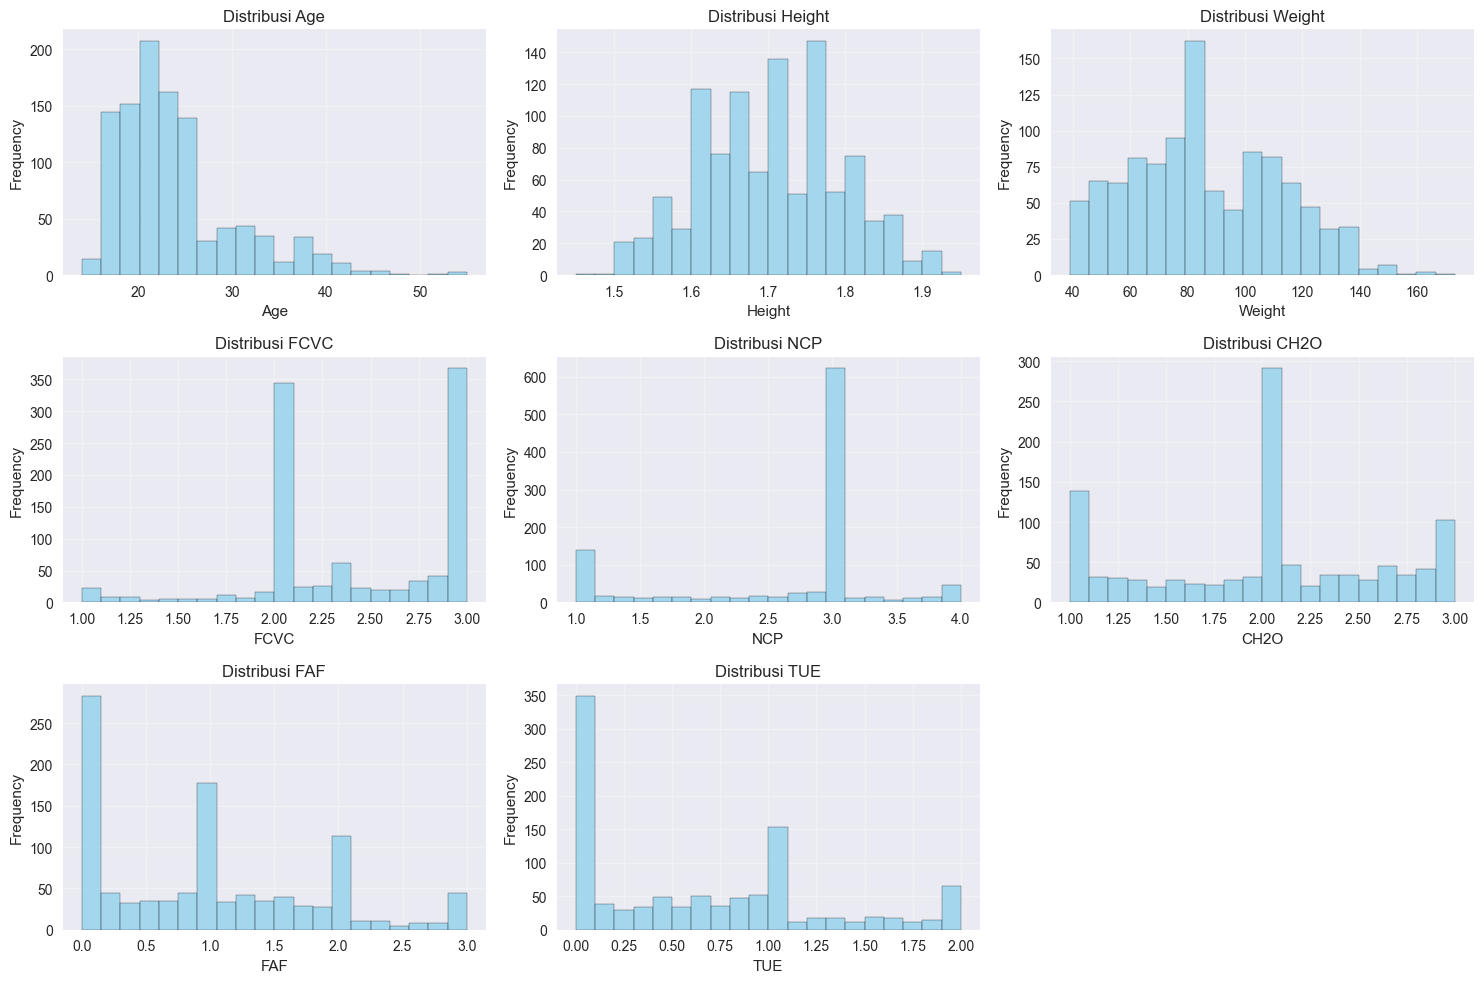

CORRELATION ANALYSIS
             Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
Age     1.000000 -0.013129  0.203558 -0.009128 -0.022931 -0.031790 -0.163297   
Height -0.013129  1.000000  0.488118 -0.036769  0.252057  0.212278  0.313454   
Weight  0.203558  0.488118  1.000000  0.199669  0.122892  0.201127 -0.025174   
FCVC   -0.009128 -0.036769  0.199669  1.000000  0.012387  0.071877  0.011441   
NCP    -0.022931  0.252057  0.122892  0.012387  1.000000  0.040925  0.162124   
CH2O   -0.031790  0.212278  0.201127  0.071877  0.040925  1.000000  0.164891   
FAF    -0.163297  0.313454 -0.025174  0.011441  0.162124  0.164891  1.000000   
TUE    -0.312781  0.032080 -0.054138 -0.095682  0.015665  0.044879  0.095162   

             TUE  
Age    -0.312781  
Height  0.032080  
Weight -0.054138  
FCVC   -0.095682  
NCP     0.015665  
CH2O    0.044879  
FAF     0.095162  
TUE     1.000000  


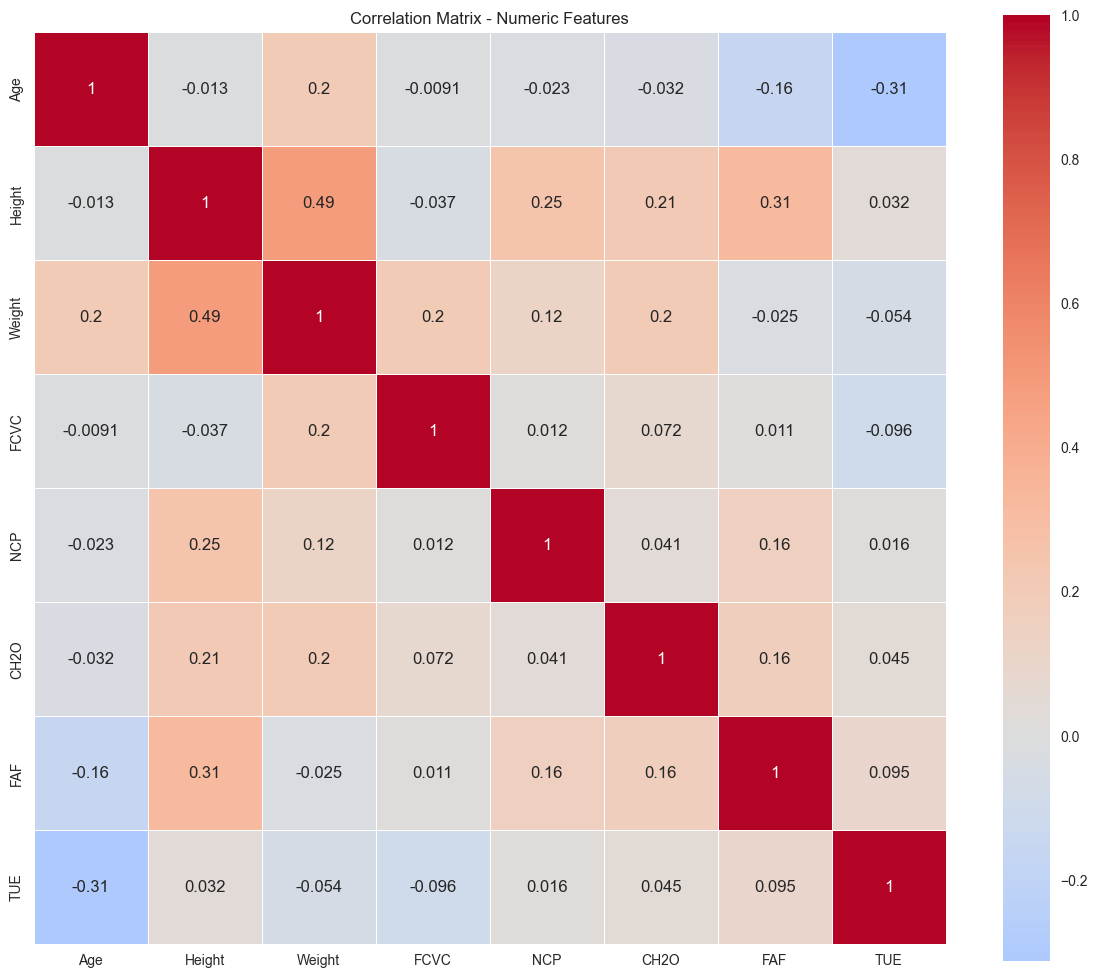

In [24]:
# Visualisasi distribusi fitur numerik
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis korelasi
print("=" * 50)
print("CORRELATION ANALYSIS")
print("=" * 50)
correlation_matrix = df[numeric_features].corr()
print(correlation_matrix)

# Heatmap korelasi
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numeric Features')
plt.tight_layout()
plt.show()


## **4. Outlier Detection dan Treatment**


Menggunakan metode IQR untuk deteksi outlier, serta clapping untuk mengatasi outliernya.

OUTLIER DETECTION

Age:
  Outliers: 80 (7.58%)
  Lower bound: 11.00
  Upper bound: 35.00
  Outlier values: [36.0, 36.0, 36.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 39.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 42.0, 42.0, 43.0, 44.0, 44.0, 44.0, 45.0, 45.0, 46.0, 46.0, 48.0, 51.0, 55.0, 55.0, 55.0]

Height:
  Outliers: 0 (0.00%)
  Lower bound: 1.43
  Upper bound: 1.96

Weight:
  Outliers: 1 (0.09%)
  Lower bound: 3.05
  Upper bound: 170.91
  Outlier values: [173.0]

FCVC:
  Outliers: 0 (0.00%)
  Lower bound: 0.50
  Upper bound: 4.50

NCP:
  Outliers: 257 (24.34%)
  Lower bound: 1.81
  Upper bound: 3.71
  Outlier values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

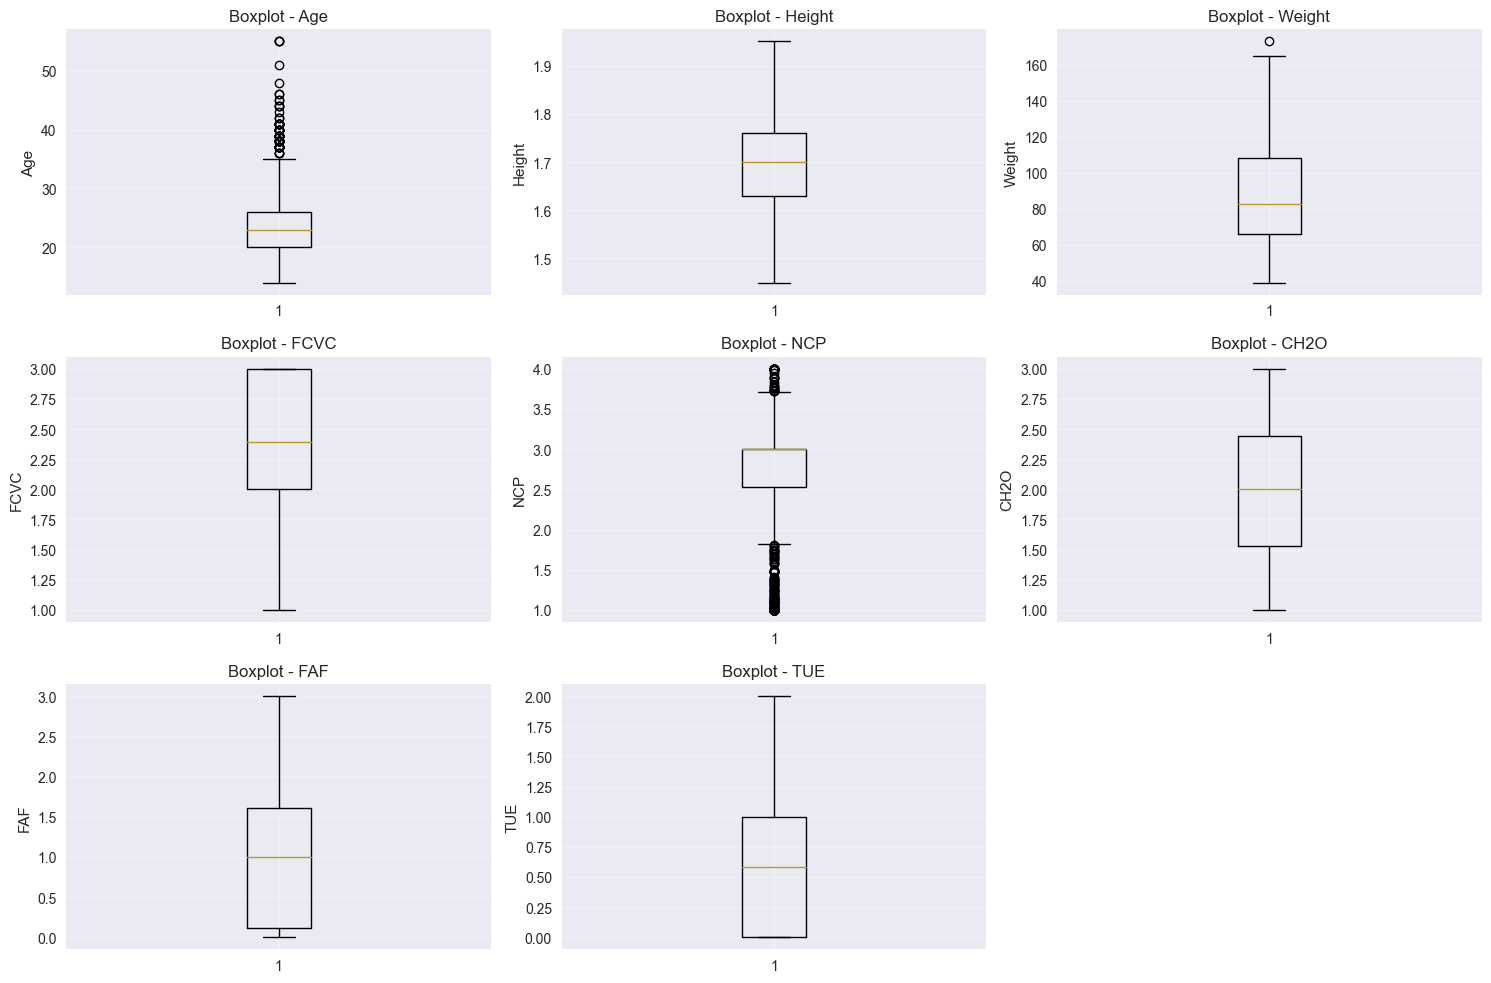

In [25]:
# Deteksi outliers menggunakan IQR method
def detect_outliers_iqr(df, column):
    """
    Deteksi outliers menggunakan IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("=" * 50)
print("OUTLIER DETECTION")
print("=" * 50)

outlier_summary = {}
for col in numeric_features:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100
    
    outlier_summary[col] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'lower_bound': lower,
        'upper_bound': upper
    }
    
    print(f"\n{col}:")
    print(f"  Outliers: {outlier_count} ({outlier_percentage:.2f}%)")
    print(f"  Lower bound: {lower:.2f}")
    print(f"  Upper bound: {upper:.2f}")
    if outlier_count > 0:
        print(f"  Outlier values: {sorted(outliers[col].values)}")

# Visualisasi outliers dengan boxplot
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df[col], vert=True)
    plt.title(f'Boxplot - {col}')
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
# Treatment outliers - Menggunakan capping method (winsorizing)
def treat_outliers_capping(df, column, lower_bound, upper_bound):
    """
    Treatment outliers dengan capping method
    """
    df_treated = df.copy()
    df_treated[column] = np.where(df_treated[column] < lower_bound, lower_bound, df_treated[column])
    df_treated[column] = np.where(df_treated[column] > upper_bound, upper_bound, df_treated[column])
    return df_treated

print("=" * 50)
print("OUTLIER TREATMENT")
print("=" * 50)

# Simpan data original untuk comparison
df_original = df.copy()

# Apply outlier treatment untuk kolom dengan outliers signifikan (>5%)
for col in numeric_features:
    if outlier_summary[col]['percentage'] > 5:  # Treat jika outliers >5%
        print(f"\nTreating outliers in {col} ({outlier_summary[col]['percentage']:.2f}% outliers)")
        df = treat_outliers_capping(df, col, 
                                   outlier_summary[col]['lower_bound'], 
                                   outlier_summary[col]['upper_bound'])
        
        # Verifikasi treatment
        outliers_after, _, _ = detect_outliers_iqr(df, col)
        print(f"Outliers after treatment: {len(outliers_after)} ({(len(outliers_after)/len(df))*100:.2f}%)")


OUTLIER TREATMENT

Treating outliers in Age (7.58% outliers)
Outliers after treatment: 0 (0.00%)

Treating outliers in NCP (24.34% outliers)
Outliers after treatment: 0 (0.00%)


## **5. Feature Engineering dan Encoding**


Untuk kolom kategorik, lakukan Encoding

CATEGORICAL FEATURES ANALYSIS

Gender:
  Unique values: 2
  Values: ['Female' 'Male']
  Value counts:
Gender
Male      532
Female    524
Name: count, dtype: int64

family_history_with_overweight:
  Unique values: 2
  Values: ['yes' 'no']
  Value counts:
family_history_with_overweight
yes    862
no     194
Name: count, dtype: int64

FAVC:
  Unique values: 2
  Values: ['no' 'yes']
  Value counts:
FAVC
yes    935
no     121
Name: count, dtype: int64

CAEC:
  Unique values: 4
  Values: ['Sometimes' 'Frequently' 'no' 'Always']
  Value counts:
CAEC
Sometimes     870
Frequently    129
Always         29
no             28
Name: count, dtype: int64

SMOKE:
  Unique values: 2
  Values: ['no' 'yes']
  Value counts:
SMOKE
no     1034
yes      22
Name: count, dtype: int64

SCC:
  Unique values: 2
  Values: ['no' 'yes']
  Value counts:
SCC
no     1001
yes      55
Name: count, dtype: int64

CALC:
  Unique values: 4
  Values: ['no' 'Sometimes' 'Frequently' 'Always']
  Value counts:
CALC
Sometimes     6

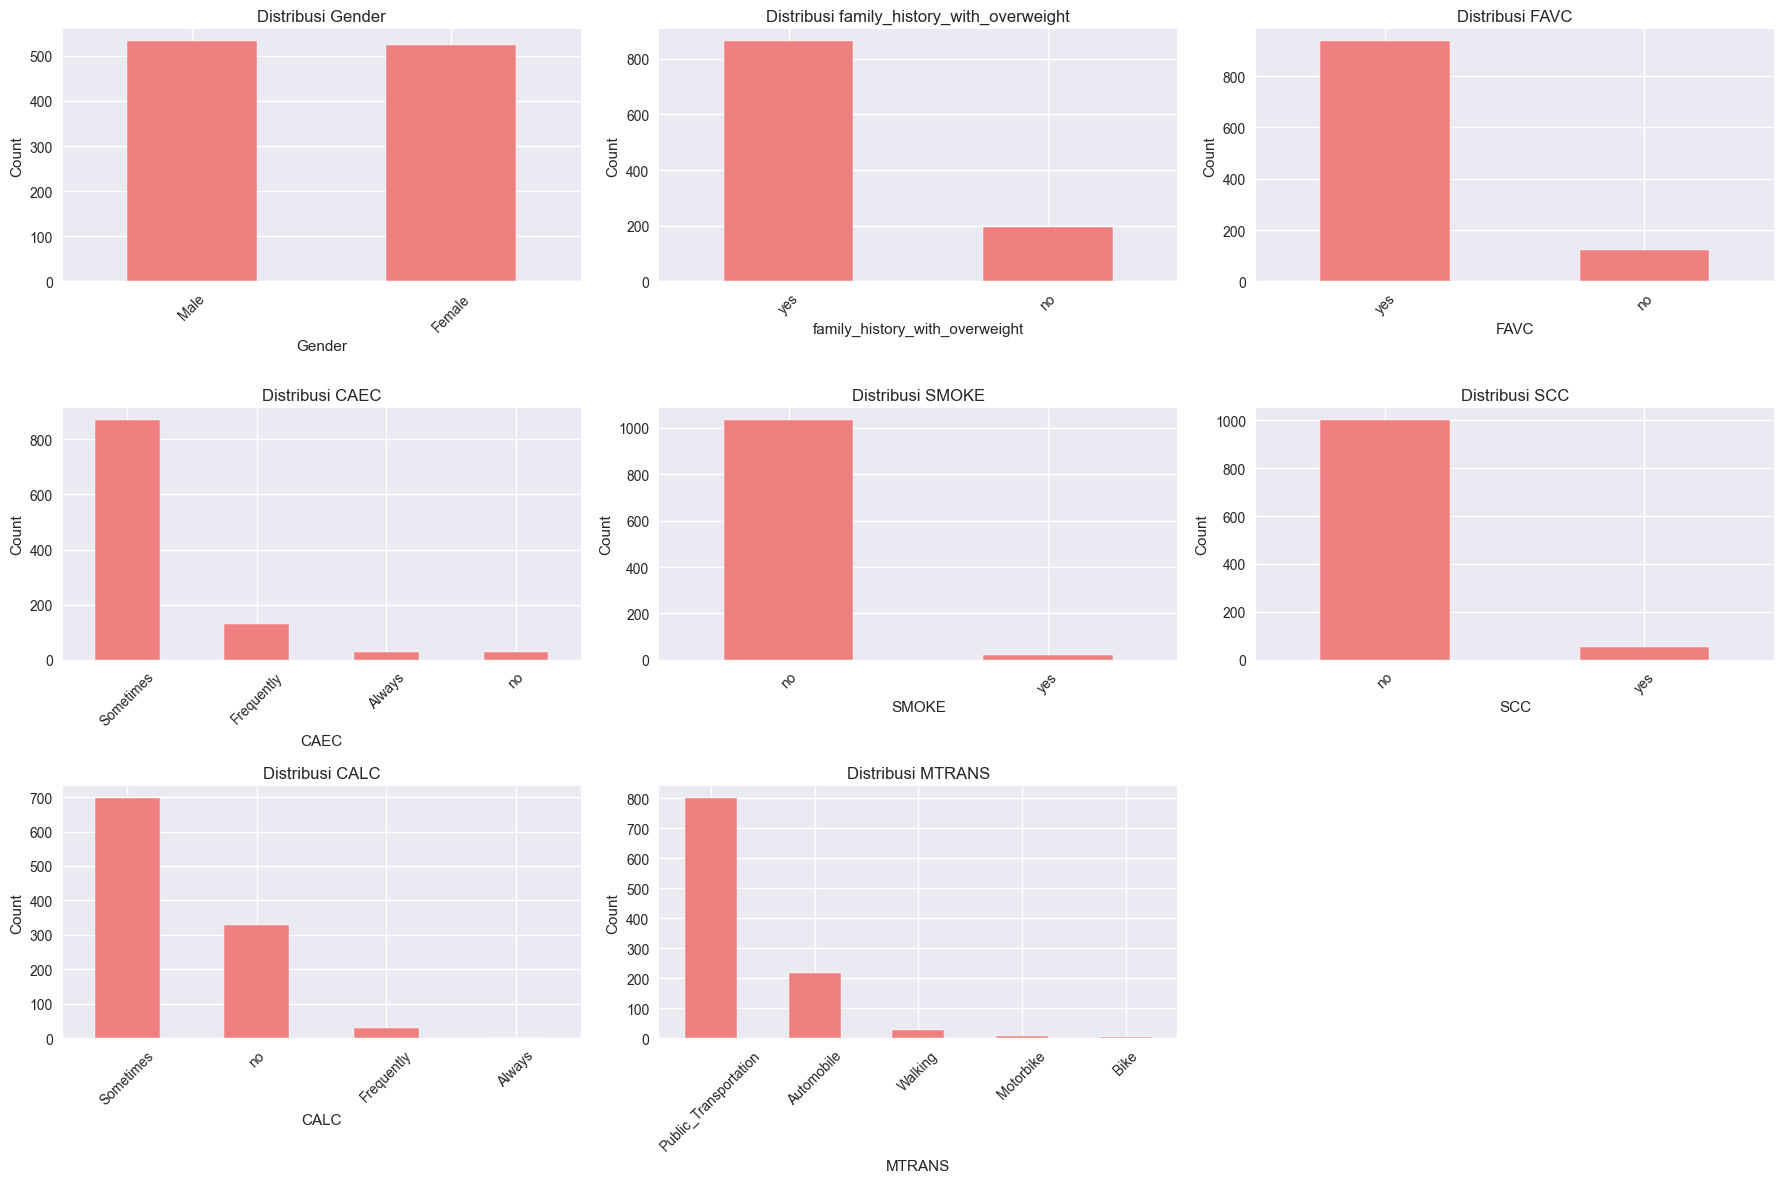

In [27]:
# Analisis fitur kategorik
print("=" * 50)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 50)

for col in categorical_features:
    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Values: {df[col].unique()}")
    print(f"  Value counts:")
    print(df[col].value_counts())

# Visualisasi distribusi fitur kategorik
n_cat_features = len(categorical_features)
if n_cat_features > 0:
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, col in enumerate(categorical_features):
        if i < 9:  # Limit to 9 plots
            df[col].value_counts().plot(kind='bar', ax=axes[i], color='lightcoral')
            axes[i].set_title(f'Distribusi {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for j in range(i+1, 9):
        axes[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()


Untuk fitur kategorik dengan 2 unique values, gunakan Label Encoding

Untuk fitur kategorik dengan >2 unique values, gunakan One-Hot Encoding

In [28]:
# Encoding untuk fitur kategorik
print("=" * 50)
print("CATEGORICAL ENCODING")
print("=" * 50)

# Siapkan data untuk encoding
df_encoded = df.copy()

# Untuk fitur kategorik dengan 2 unique values, gunakan Label Encoding
# Untuk fitur kategorik dengan >2 unique values, gunakan One-Hot Encoding

binary_features = []
multi_features = []

for col in categorical_features:
    unique_count = df[col].nunique()
    if unique_count == 2:
        binary_features.append(col)
    else:
        multi_features.append(col)

print(f"Binary features (Label Encoding): {binary_features}")
print(f"Multi-class features (One-Hot Encoding): {multi_features}")

# Label Encoding untuk fitur binary
label_encoders = {}
for col in binary_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"\n{col} Label Encoding:")
    print(f"  Original → Encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# One-Hot Encoding untuk fitur multi-class
if multi_features:
    df_encoded = pd.get_dummies(df_encoded, columns=multi_features, prefix=multi_features)
    print(f"\nOne-Hot Encoding applied to: {multi_features}")
    print(f"New columns created: {[col for col in df_encoded.columns if any(prefix in col for prefix in multi_features)]}")

# Target encoding
target_encoder = LabelEncoder()
df_encoded['NObeyesdad_encoded'] = target_encoder.fit_transform(df_encoded['NObeyesdad'])

print(f"\nTarget encoding:")
print(f"Classes: {target_encoder.classes_}")
print(f"Encoded values: {target_encoder.transform(target_encoder.classes_)}")

print(f"\nFinal dataset shape: {df_encoded.shape}")
print(f"Original shape: {df.shape}")
print(f"New features added: {df_encoded.shape[1] - df.shape[1]}")


CATEGORICAL ENCODING
Binary features (Label Encoding): ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
Multi-class features (One-Hot Encoding): ['CAEC', 'CALC', 'MTRANS']

Gender Label Encoding:
  Original → Encoded: {'Female': 0, 'Male': 1}

family_history_with_overweight Label Encoding:
  Original → Encoded: {'no': 0, 'yes': 1}

FAVC Label Encoding:
  Original → Encoded: {'no': 0, 'yes': 1}

SMOKE Label Encoding:
  Original → Encoded: {'no': 0, 'yes': 1}

SCC Label Encoding:
  Original → Encoded: {'no': 0, 'yes': 1}

One-Hot Encoding applied to: ['CAEC', 'CALC', 'MTRANS']
New columns created: ['CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']

Target encoding:
Classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'O

## **6. Data Splitting dan Standardization**


In [29]:
# Persiapan data untuk modeling
print("=" * 50)
print("DATA PREPARATION FOR MODELING")
print("=" * 50)

# Pisahkan features dan target
# Exclude original categorical columns dan target
features_to_exclude = ['NObeyesdad', 'NObeyesdad_encoded']
X = df_encoded.drop(columns=features_to_exclude)
y = df_encoded['NObeyesdad_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Stratified split untuk menjaga proporsi kelas
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Cek distribusi kelas di train dan test set
print("\nDistribusi kelas di train set:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nDistribusi kelas di test set:")
print(pd.Series(y_test).value_counts().sort_index())

# Proporsi kelas
print("\nProporsi kelas di train set:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index().round(4))
print("\nProporsi kelas di test set:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index().round(4))


DATA PREPARATION FOR MODELING
Features shape: (1056, 26)
Target shape: (1056,)
Feature columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CAEC_Always', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'CALC_Always', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no', 'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation', 'MTRANS_Walking']

Train set shape: (844, 26)
Test set shape: (212, 26)

Distribusi kelas di train set:
NObeyesdad_encoded
0    109
1    114
2    141
3    119
4    129
5    116
6    116
Name: count, dtype: int64

Distribusi kelas di test set:
NObeyesdad_encoded
0    27
1    29
2    35
3    30
4    33
5    29
6    29
Name: count, dtype: int64

Proporsi kelas di train set:
NObeyesdad_encoded
0    0.1291
1    0.1351
2    0.1671
3    0.1410
4    0.1528
5    0.1374
6    0.1374
Name: proportion, dtype: float64

Proporsi kelas di test set:
NObeyesdad_encoded

### **Standarisasi Data**

FEATURE STANDARDIZATION


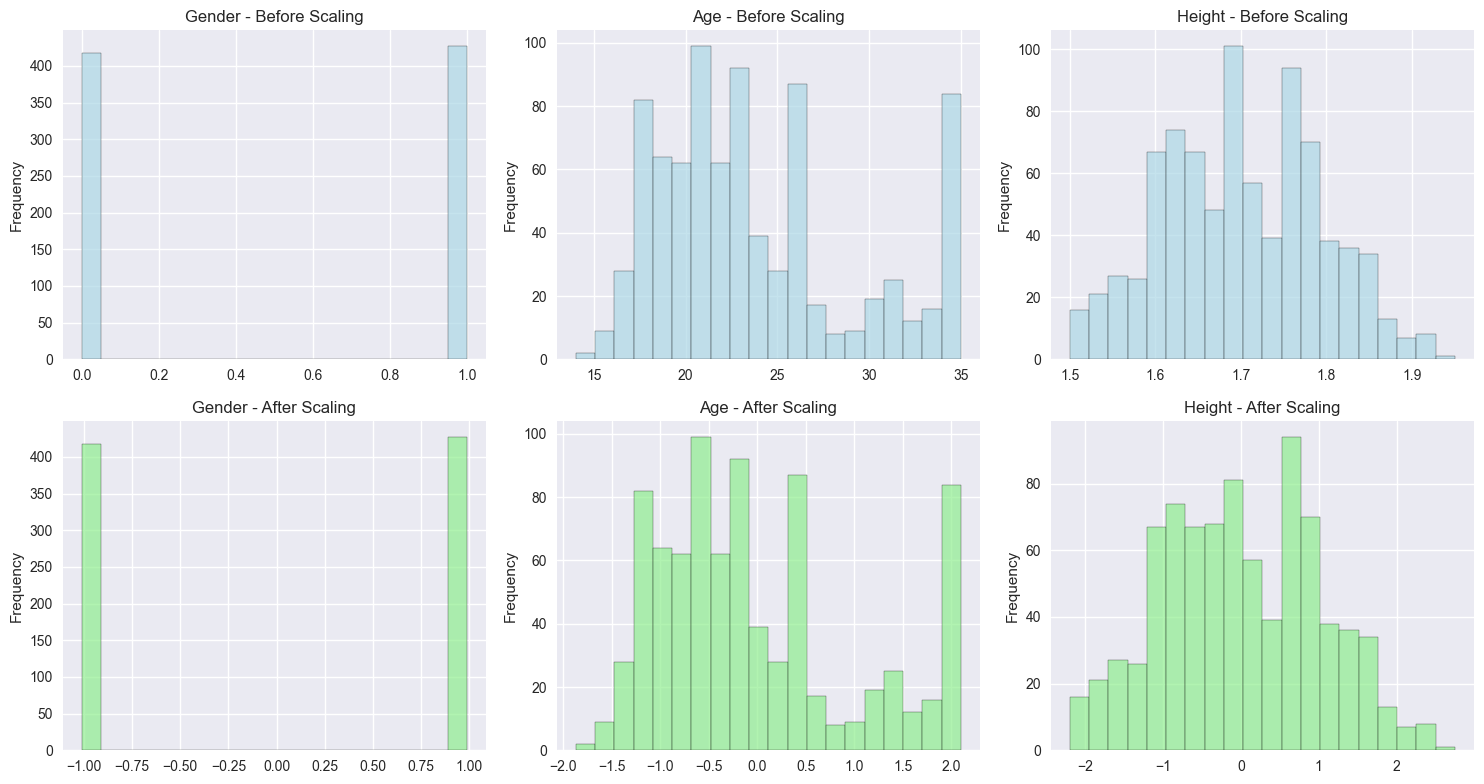


Data siap untuk modeling!
X_train_scaled shape: (844, 26)
X_test_scaled shape: (212, 26)
y_train shape: (844,)
y_test shape: (212,)


In [ ]:
# Standardization menggunakan StandardScaler
print("=" * 50)
print("FEATURE STANDARDIZATION")
print("=" * 50)

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler pada training data dan transform training dan test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert kembali ke DataFrame untuk kemudahan analisis
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Pilih beberapa feature untuk perbandingan
sample_features = X.columns[:3]  # Ambil 3 feature pertama
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, feature in enumerate(sample_features):
    # Before scaling
    axes[0, i].hist(X_train[feature], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
    axes[0, i].set_title(f'{feature} - Before Scaling')
    axes[0, i].set_ylabel('Frequency')
    
    # After scaling
    axes[1, i].hist(X_train_scaled[feature], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, i].set_title(f'{feature} - After Scaling')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nData siap untuk modeling!")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

## **7. Machine Learning Modeling**


### **7.1 Support Vector Machine (SVM)**


In [31]:
# Support Vector Machine dengan Grid Search
print("=" * 50)
print("SUPPORT VECTOR MACHINE (SVM) MODELING")
print("=" * 50)

# Define parameter grid untuk SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4]  # untuk polynomial kernel
}

# Inisialisasi SVM
svm_model = SVC(random_state=42)

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Memulai Grid Search untuk SVM...")
print(f"Parameter grid: {len(svm_param_grid['C']) * len(svm_param_grid['kernel']) * len(svm_param_grid['gamma']) * len(svm_param_grid['degree'])} kombinasi")

# Grid Search dengan Cross Validation
svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,  # Gunakan semua CPU cores
    verbose=1
)

# Fit grid search
svm_grid_search.fit(X_train_scaled, y_train)

print("\nGrid Search SVM completed!")
print(f"Best parameters: {svm_grid_search.best_params_}")
print(f"Best cross-validation score: {svm_grid_search.best_score_:.4f}")

# Get best SVM model
best_svm = svm_grid_search.best_estimator_

# Prediksi pada test set
svm_train_pred = best_svm.predict(X_train_scaled)
svm_test_pred = best_svm.predict(X_test_scaled)

# Evaluasi performa
svm_train_accuracy = accuracy_score(y_train, svm_train_pred)
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)

print(f"\nSVM Training Accuracy: {svm_train_accuracy:.4f}")
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")

# Cross-validation score
svm_cv_scores = cross_val_score(best_svm, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"SVM CV Accuracy: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")


SUPPORT VECTOR MACHINE (SVM) MODELING
Memulai Grid Search untuk SVM...
Parameter grid: 216 kombinasi
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Grid Search SVM completed!
Best parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9490

SVM Training Accuracy: 0.9953
SVM Test Accuracy: 0.9434
SVM CV Accuracy: 0.9490 ± 0.0172



SVM CLASSIFICATION REPORT
Classification Report - Training Set:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00       109
      Normal_Weight       1.00      1.00      1.00       114
     Obesity_Type_I       0.99      1.00      1.00       141
    Obesity_Type_II       1.00      1.00      1.00       119
   Obesity_Type_III       1.00      1.00      1.00       129
 Overweight_Level_I       0.98      0.98      0.98       116
Overweight_Level_II       0.99      0.98      0.99       116

           accuracy                           1.00       844
          macro avg       1.00      1.00      1.00       844
       weighted avg       1.00      1.00      1.00       844


Classification Report - Test Set:
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      1.00      0.95        27
      Normal_Weight       0.96      0.83      0.89        29
     Obesity_Type_I       0.94      0.97  

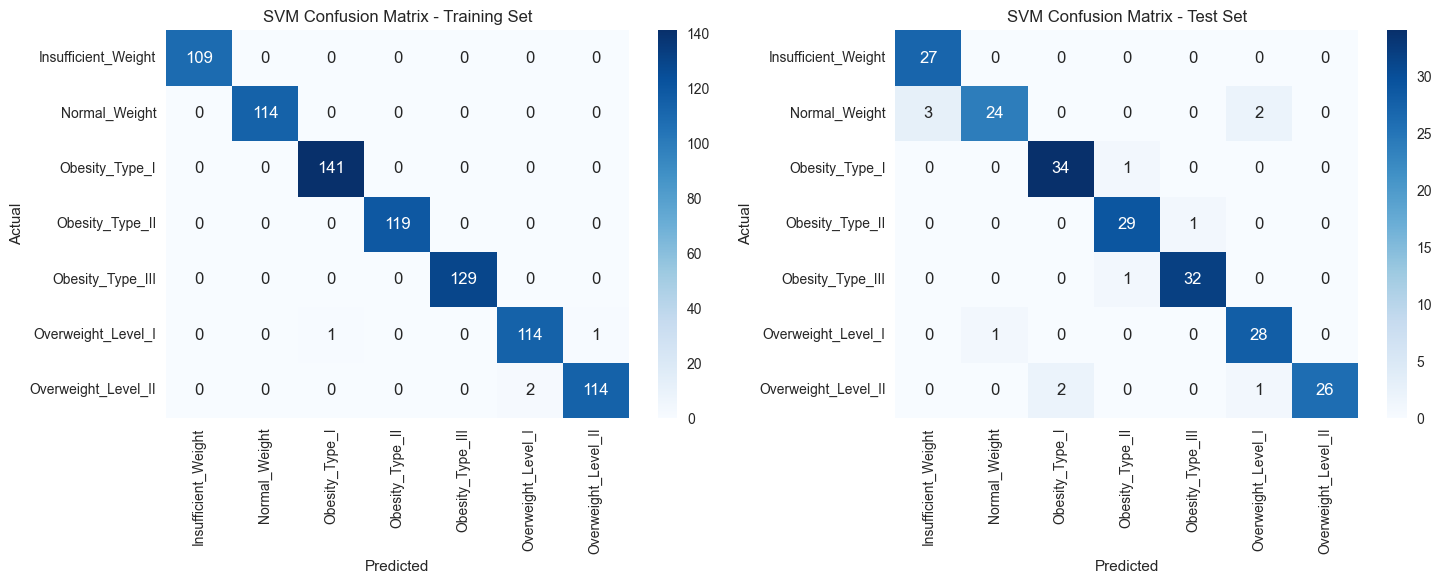


SVM Results Summary:
Train Accuracy: 0.9953
Test Accuracy: 0.9434
CV Score: 0.9490 ± 0.0172
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [32]:
# Laporan klasifikasi SVM
print("\n" + "=" * 50)
print("SVM CLASSIFICATION REPORT")
print("=" * 50)

# Get class names dari target encoder
class_names = target_encoder.classes_

print("Classification Report - Training Set:")
print(classification_report(y_train, svm_train_pred, target_names=class_names))

print("\nClassification Report - Test Set:")
print(classification_report(y_test, svm_test_pred, target_names=class_names))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
cm_train = confusion_matrix(y_train, svm_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('SVM Confusion Matrix - Training Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test confusion matrix
cm_test = confusion_matrix(y_test, svm_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('SVM Confusion Matrix - Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Simpan hasil SVM
svm_results = {
    'model': best_svm,
    'train_accuracy': svm_train_accuracy,
    'test_accuracy': svm_test_accuracy,
    'cv_mean': svm_cv_scores.mean(),
    'cv_std': svm_cv_scores.std(),
    'best_params': svm_grid_search.best_params_,
    'train_predictions': svm_train_pred,
    'test_predictions': svm_test_pred
}

print(f"\nSVM Results Summary:")
print(f"Train Accuracy: {svm_train_accuracy:.4f}")
print(f"Test Accuracy: {svm_test_accuracy:.4f}")
print(f"CV Score: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")
print(f"Best Parameters: {svm_grid_search.best_params_}")


### **7.2 XGBoost Classifier**


In [33]:
# XGBoost Classifier dengan Grid Search
print("=" * 50)
print("XGBOOST CLASSIFIER MODELING")
print("=" * 50)

# Define parameter grid untuk XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Inisialisasi XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')

print("Memulai Grid Search untuk XGBoost...")
print(f"Parameter grid: {len(xgb_param_grid['n_estimators']) * len(xgb_param_grid['max_depth']) * len(xgb_param_grid['learning_rate']) * len(xgb_param_grid['subsample']) * len(xgb_param_grid['colsample_bytree'])} kombinasi")

# Grid Search dengan Cross Validation
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,  # Gunakan semua CPU cores
    verbose=1
)

# Fit grid search
xgb_grid_search.fit(X_train_scaled, y_train)

print("\nGrid Search XGBoost completed!")
print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best cross-validation score: {xgb_grid_search.best_score_:.4f}")

# Get best XGBoost model
best_xgb = xgb_grid_search.best_estimator_

# Prediksi pada test set
xgb_train_pred = best_xgb.predict(X_train_scaled)
xgb_test_pred = best_xgb.predict(X_test_scaled)

# Evaluasi performa
xgb_train_accuracy = accuracy_score(y_train, xgb_train_pred)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_pred)

print(f"\nXGBoost Training Accuracy: {xgb_train_accuracy:.4f}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

# Cross-validation score
xgb_cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"XGBoost CV Accuracy: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")


XGBOOST CLASSIFIER MODELING
Memulai Grid Search untuk XGBoost...
Parameter grid: 243 kombinasi
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Grid Search XGBoost completed!
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score: 0.9455

XGBoost Training Accuracy: 1.0000
XGBoost Test Accuracy: 0.9528
XGBoost CV Accuracy: 0.9455 ± 0.0243



XGBOOST CLASSIFICATION REPORT
Classification Report - Training Set:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00       109
      Normal_Weight       1.00      1.00      1.00       114
     Obesity_Type_I       1.00      1.00      1.00       141
    Obesity_Type_II       1.00      1.00      1.00       119
   Obesity_Type_III       1.00      1.00      1.00       129
 Overweight_Level_I       1.00      1.00      1.00       116
Overweight_Level_II       1.00      1.00      1.00       116

           accuracy                           1.00       844
          macro avg       1.00      1.00      1.00       844
       weighted avg       1.00      1.00      1.00       844


Classification Report - Test Set:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        27
      Normal_Weight       0.91      1.00      0.95        29
     Obesity_Type_I       0.92      0.

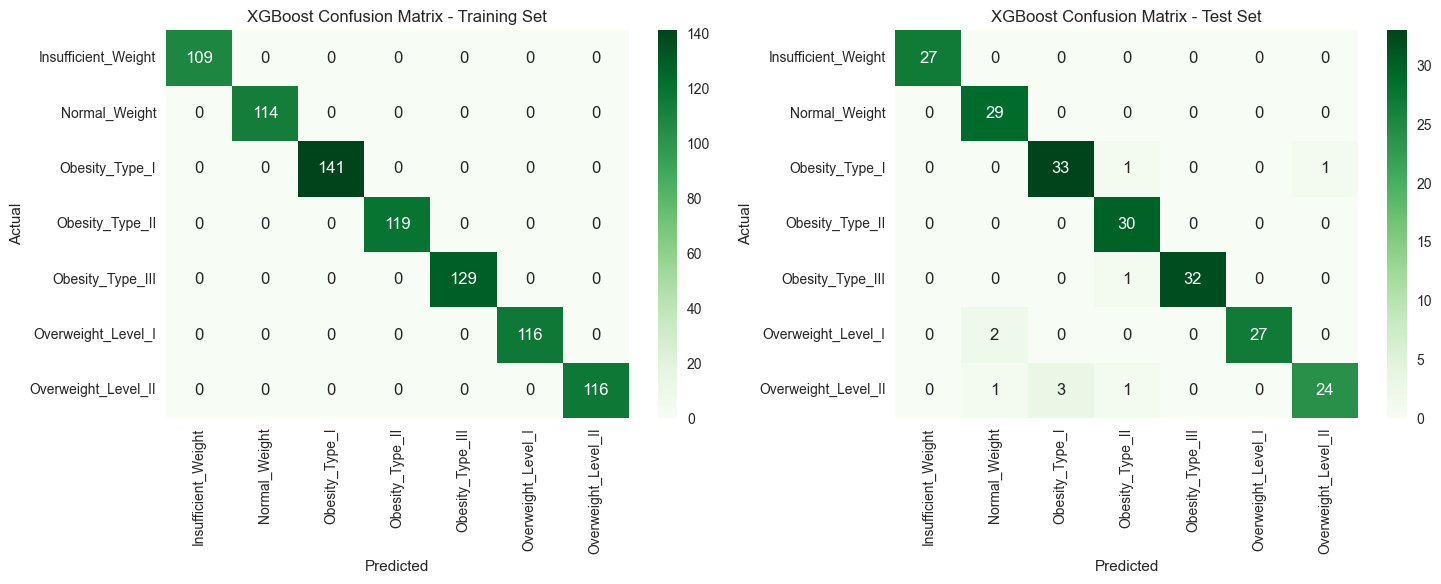


XGBoost Results Summary:
Train Accuracy: 1.0000
Test Accuracy: 0.9528
CV Score: 0.9455 ± 0.0243
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}


In [36]:
# Laporan klasifikasi XGBoost
print("\n" + "=" * 50)
print("XGBOOST CLASSIFICATION REPORT")
print("=" * 50)

print("Classification Report - Training Set:")
print(classification_report(y_train, xgb_train_pred, target_names=class_names))

print("\nClassification Report - Test Set:")
print(classification_report(y_test, xgb_test_pred, target_names=class_names))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training confusion matrix
cm_train_xgb = confusion_matrix(y_train, xgb_train_pred)
sns.heatmap(cm_train_xgb, annot=True, fmt='d', cmap='Greens', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('XGBoost Confusion Matrix - Training Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Test confusion matrix
cm_test_xgb = confusion_matrix(y_test, xgb_test_pred)
sns.heatmap(cm_test_xgb, annot=True, fmt='d', cmap='Greens', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix - Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Simpan hasil XGBoost
xgb_results = {
    'model': best_xgb,
    'train_accuracy': xgb_train_accuracy,
    'test_accuracy': xgb_test_accuracy,
    'cv_mean': xgb_cv_scores.mean(),
    'cv_std': xgb_cv_scores.std(),
    'best_params': xgb_grid_search.best_params_,
    'train_predictions': xgb_train_pred,
    'test_predictions': xgb_test_pred
}

print(f"\nXGBoost Results Summary:")
print(f"Train Accuracy: {xgb_train_accuracy:.4f}")
print(f"Test Accuracy: {xgb_test_accuracy:.4f}")
print(f"CV Score: {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")
print(f"Best Parameters: {xgb_grid_search.best_params_}")


## **8. Model Comparison dan Selection**


PERBANDINGAN PERFORMA MODEL
     Model  Train_Accuracy  Test_Accuracy  CV_Mean  CV_Std  Overfitting
0      SVM          0.9953         0.9434   0.9490  0.0172       0.0519
1  XGBoost          1.0000         0.9528   0.9455  0.0243       0.0472


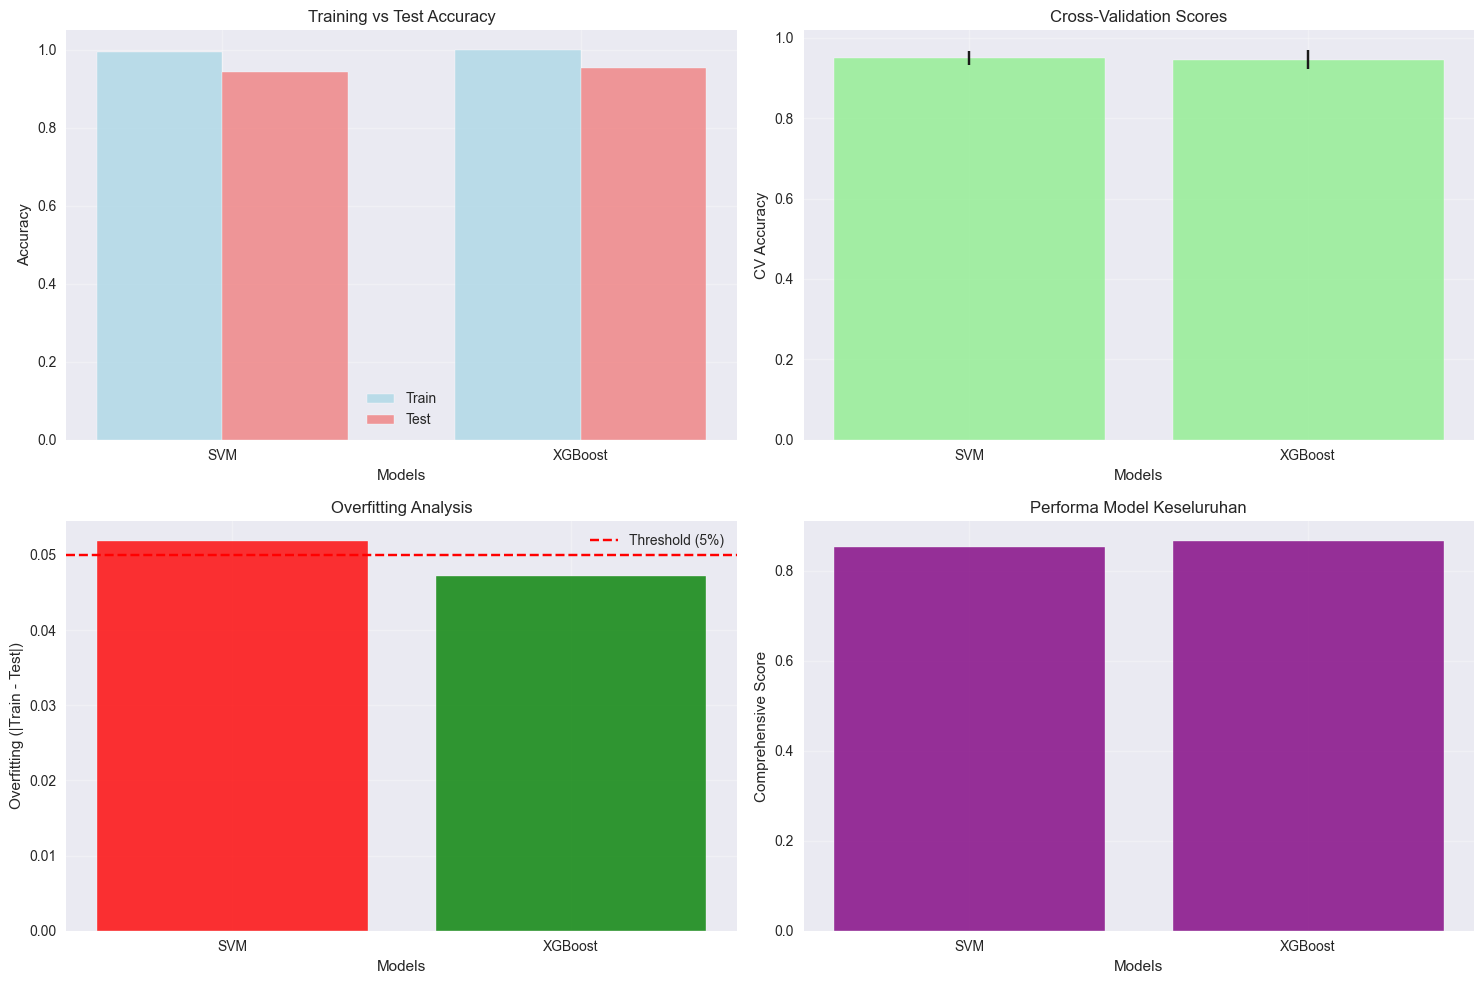


SELEKSI MODEL
SVM Comprehensive Score: 0.8527
XGBoost Comprehensive Score: 0.8657

🏆 BEST MODEL: XGBoost
Test Accuracy: 0.9528
CV Score: 0.9455 ± 0.0243
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}

Tabel Perbandingan Model
                Metric     SVM XGBoost   Winner
0    Training Accuracy  0.9953  1.0000  XGBoost
1        Test Accuracy  0.9434  0.9528  XGBoost
2              CV Mean  0.9490  0.9455      SVM
3               CV Std  0.0172  0.0243      SVM
4          Overfitting  0.0519  0.0472  XGBoost
5  Comprehensive Score  0.8527  0.8657  XGBoost


In [47]:
# Perbandingan Performa Model
print("=" * 70)
print("PERBANDINGAN PERFORMA MODEL")
print("=" * 70)

# Buat DataFrame perbandingan
comparison_data = {
    'Model': ['SVM', 'XGBoost'],
    'Train_Accuracy': [svm_results['train_accuracy'], xgb_results['train_accuracy']],
    'Test_Accuracy': [svm_results['test_accuracy'], xgb_results['test_accuracy']],
    'CV_Mean': [svm_results['cv_mean'], xgb_results['cv_mean']],
    'CV_Std': [svm_results['cv_std'], xgb_results['cv_std']],
    'Overfitting': [
        svm_results['train_accuracy'] - svm_results['test_accuracy'],
        xgb_results['train_accuracy'] - xgb_results['test_accuracy']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# komparasi model
models = ['SVM', 'XGBoost']
train_scores = [svm_results['train_accuracy'], xgb_results['train_accuracy']]
test_scores = [svm_results['test_accuracy'], xgb_results['test_accuracy']]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, train_scores, width, label='Train', alpha=0.8, color='lightblue')
axes[0, 0].bar(x + width/2, test_scores, width, label='Test', alpha=0.8, color='lightcoral')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training vs Test Accuracy')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# CV scores with error bars
cv_means = [svm_results['cv_mean'], xgb_results['cv_mean']]
cv_stds = [svm_results['cv_std'], xgb_results['cv_std']]

axes[0, 1].bar(models, cv_means, yerr=cv_stds, capsize=10, alpha=0.8, color='lightgreen')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('CV Accuracy')
axes[0, 1].set_title('Cross-Validation Scores')
axes[0, 1].grid(True, alpha=0.3)

# Analisis overfitting
overfitting = [abs(train_scores[i] - test_scores[i]) for i in range(len(models))]
colors = ['red' if x > 0.05 else 'green' for x in overfitting]
axes[1, 0].bar(models, overfitting, alpha=0.8, color=colors)
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Overfitting (|Train - Test|)')
axes[1, 0].set_title('Overfitting Analysis')
axes[1, 0].axhline(y=0.05, color='red', linestyle='--', label='Threshold (5%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comprehensive score (weighted average)
# Weight: Test Accuracy (50%), CV Mean (30%), Low Overfitting (20%)
def calculate_comprehensive_score(test_acc, cv_mean, overfitting):
    # Normalize overfitting (lower is better)
    overfitting_score = max(0, 1 - overfitting / 0.1)  # 10% overfitting = 0 score
    return 0.5 * test_acc + 0.3 * cv_mean + 0.2 * overfitting_score

comprehensive_scores = [
    calculate_comprehensive_score(test_scores[i], cv_means[i], overfitting[i]) 
    for i in range(len(models))
]

axes[1, 1].bar(models, comprehensive_scores, alpha=0.8, color='purple')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Comprehensive Score')
axes[1, 1].set_title('Performa Model Keseluruhan')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tentukan model terbaik
print("\n" + "=" * 50)
print("SELEKSI MODEL")
print("=" * 50)

print(f"SVM Comprehensive Score: {comprehensive_scores[0]:.4f}")
print(f"XGBoost Comprehensive Score: {comprehensive_scores[1]:.4f}")

if comprehensive_scores[0] > comprehensive_scores[1]:
    best_model_name = "SVM"
    best_model = svm_results['model']
    best_results = svm_results
else:
    best_model_name = "XGBoost"
    best_model = xgb_results['model']
    best_results = xgb_results

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {best_results['test_accuracy']:.4f}")
print(f"CV Score: {best_results['cv_mean']:.4f} ± {best_results['cv_std']:.4f}")
print(f"Best Parameters: {best_results['best_params']}")

# Detailed comparison table
print("\n" + "=" * 70)
print("Tabel Perbandingan Model")
print("=" * 70)
detailed_comparison = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Test Accuracy', 'CV Mean', 'CV Std', 
               'Overfitting', 'Comprehensive Score'],
    'SVM': [
        f"{svm_results['train_accuracy']:.4f}",
        f"{svm_results['test_accuracy']:.4f}",
        f"{svm_results['cv_mean']:.4f}",
        f"{svm_results['cv_std']:.4f}",
        f"{overfitting[0]:.4f}",
        f"{comprehensive_scores[0]:.4f}"
    ],
    'XGBoost': [
        f"{xgb_results['train_accuracy']:.4f}",
        f"{xgb_results['test_accuracy']:.4f}",
        f"{xgb_results['cv_mean']:.4f}",
        f"{xgb_results['cv_std']:.4f}",
        f"{overfitting[1]:.4f}",
        f"{comprehensive_scores[1]:.4f}"
    ],
    'Winner': [
        'SVM' if svm_results['train_accuracy'] > xgb_results['train_accuracy'] else 'XGBoost',
        'SVM' if svm_results['test_accuracy'] > xgb_results['test_accuracy'] else 'XGBoost',
        'SVM' if svm_results['cv_mean'] > xgb_results['cv_mean'] else 'XGBoost',
        'SVM' if svm_results['cv_std'] < xgb_results['cv_std'] else 'XGBoost',
        'SVM' if overfitting[0] < overfitting[1] else 'XGBoost',
        'SVM' if comprehensive_scores[0] > comprehensive_scores[1] else 'XGBoost'
    ]
})

print(detailed_comparison)


## **9. Model Deployment - Save Best Model**


In [48]:
# Save Best Model dan Pipeline Components
import os
print("=" * 50)
print("MENYIMPAN MODEL TERBAIK DAN KOMPONEN PIPELINE")
print("=" * 50)

# Buat dictionary dengan semua komponen yang diperlukan untuk deployment
model_pipeline = {
    'best_model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'target_encoder': target_encoder,
    'feature_columns': list(X.columns),
    'original_columns': list(df.columns),
    'binary_features': binary_features,
    'multi_features': multi_features,
    'categorical_features': categorical_features,
    'numeric_features': numeric_features,
    'class_names': class_names,
    'model_performance': best_results,
    'preprocessing_info': {
        'outlier_treatment': 'IQR capping method',
        'missing_values': 'Median for numeric, Mode for categorical',
        'encoding': 'Label encoding for binary, One-hot for multi-class',
        'scaling': 'StandardScaler'
    }
}

# Save model pipeline
model_filename = f'best_obesity_classifier_{best_model_name.lower()}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_pipeline, f)

print(f"✅ Model pipeline disimpan sebagai: {model_filename}")

# Save individual components untuk fleksibilitas
components_to_save = {
    'best_model': (best_model, f'model_{best_model_name.lower()}.pkl'),
    'scaler': (scaler, 'scaler.pkl'),
    'target_encoder': (target_encoder, 'target_encoder.pkl'),
    'label_encoders': (label_encoders, 'label_encoders.pkl')
}

print(f"\nMenyimpan komponen individual:")
for component_name, (component, filename) in components_to_save.items():
    with open(filename, 'wb') as f:
        pickle.dump(component, f)
    print(f"✅ {component_name} saved as: {filename}")

# Verifikasi penyimpanan dengan load test
print(f"\n" + "=" * 50)
print("VERIFIKASI - MEMUAT MODEL YANG DISIMPAN")
print("=" * 50)

try:
    with open(model_filename, 'rb') as f:
        loaded_pipeline = pickle.load(f)
    
    print("✅ Model pipeline loaded successfully!")
    print(f"Loaded model: {loaded_pipeline['model_name']}")
    print(f"Feature count: {len(loaded_pipeline['feature_columns'])}")
    print(f"Classes: {loaded_pipeline['class_names']}")
    
    # Test prediction dengan data sample
    sample_data = X_test_scaled.iloc[:3]  # Ambil 3 sample
    predictions = loaded_pipeline['best_model'].predict(sample_data)
    predicted_classes = loaded_pipeline['target_encoder'].inverse_transform(predictions)
    
    print(f"\nTest predictions on 3 samples:")
    for i, pred_class in enumerate(predicted_classes):
        print(f"Sample {i+1}: {pred_class}")
        
except Exception as e:
    print(f"❌ Error loading model: {e}")

print(f"\n🎉 Model deployment siap!")
print(f"File model utama: {model_filename}")
print(f"Ukuran: {os.path.getsize(model_filename) / 1024:.2f} KB")


MENYIMPAN MODEL TERBAIK DAN KOMPONEN PIPELINE
✅ Model pipeline disimpan sebagai: best_obesity_classifier_xgboost.pkl

Menyimpan komponen individual:
✅ best_model saved as: model_xgboost.pkl
✅ scaler saved as: scaler.pkl
✅ target_encoder saved as: target_encoder.pkl
✅ label_encoders saved as: label_encoders.pkl

VERIFIKASI - MEMUAT MODEL YANG DISIMPAN
✅ Model pipeline loaded successfully!
Loaded model: XGBoost
Feature count: 26
Classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']

Test predictions on 3 samples:
Sample 1: Overweight_Level_I
Sample 2: Insufficient_Weight
Sample 3: Obesity_Type_II

🎉 Model deployment siap!
File model utama: best_obesity_classifier_xgboost.pkl
Ukuran: 1345.97 KB


## **10. Summary dan Kesimpulan**


In [49]:
# SUMMARY DAN KESIMPULAN LENGKAP
print("🎯 " + "=" * 60)
print("RANGKUMAN LENGKAP PROYEK KLASIFIKASI OBESITAS")
print("=" * 68)

print("\n📊 INFORMASI DATASET:")
print(f"• Total sampel: {df.shape[0]}")
print(f"• Jumlah fitur: {len(numeric_features) + len(categorical_features)}")
print(f"  - Fitur numerik: {len(numeric_features)}")
print(f"  - Fitur kategorik: {len(categorical_features)}")
print(f"• Kelas target: {len(class_names)} ({', '.join(class_names)})")

print(f"\n🔧 PREPROCESSING YANG DILAKUKAN:")
print(f"1. ✅ Cleaning kolom Age (format '20 years' → 20)")
print(f"2. ✅ Handling missing values (Median/Mode imputation)")
print(f"3. ✅ Outlier detection dan treatment (IQR capping method)")
print(f"4. ✅ Categorical encoding:")
print(f"   - Label encoding: {binary_features}")
print(f"   - One-hot encoding: {multi_features}")
print(f"5. ✅ Feature standardization (StandardScaler)")

print(f"\n🤖 MODEL YANG DILATIH:")
print(f"1. SVM dengan Grid Search hyperparameter tuning")
print(f"2. XGBoost dengan Grid Search hyperparameter tuning")

print(f"\n📈 HASIL PERFORMA MODEL:")
print(f"┌────────────────────┬──────────┬──────────┐")
print(f"│ Metric             │ SVM      │ XGBoost  │")
print(f"├────────────────────┼──────────┼──────────┤")
print(f"│ Training Accuracy  │ {svm_results['train_accuracy']:.4f}   │ {xgb_results['train_accuracy']:.4f}   │")
print(f"│ Test Accuracy      │ {svm_results['test_accuracy']:.4f}   │ {xgb_results['test_accuracy']:.4f}   │")
print(f"│ CV Mean ± Std      │ {svm_results['cv_mean']:.3f}±{svm_results['cv_std']:.3f}│ {xgb_results['cv_mean']:.3f}±{xgb_results['cv_std']:.3f}│")
print(f"│ Overfitting        │ {abs(svm_results['train_accuracy'] - svm_results['test_accuracy']):.4f}   │ {abs(xgb_results['train_accuracy'] - xgb_results['test_accuracy']):.4f}   │")
print(f"└────────────────────┴──────────┴──────────┘")

print(f"\n🏆 MODEL TERPILIH: {best_model_name}")
print(f"• Test Accuracy: {best_results['test_accuracy']:.4f}")
print(f"• Cross-Validation: {best_results['cv_mean']:.4f} ± {best_results['cv_std']:.4f}")
print(f"• Hyperparameters terbaik: {best_results['best_params']}")

print(f"\n💾 FILES YANG DISIMPAN:")
print(f"• {model_filename} - Complete model pipeline")
print(f"• model_{best_model_name.lower()}.pkl - Best model")
print(f"• scaler.pkl - StandardScaler")
print(f"• target_encoder.pkl - Target label encoder")
print(f"• label_encoders.pkl - Categorical encoders")


print(f"\n✅ PROYEK SELESAI - SIAP UNTUK DEPLOYMENT!")
print("=" * 68)

🎯 ============================================================
RANGKUMAN LENGKAP PROYEK KLASIFIKASI OBESITAS

📊 INFORMASI DATASET:
• Total sampel: 1056
• Jumlah fitur: 16
  - Fitur numerik: 8
  - Fitur kategorik: 8
• Kelas target: 7 (Insufficient_Weight, Normal_Weight, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III, Overweight_Level_I, Overweight_Level_II)

🔧 PREPROCESSING YANG DILAKUKAN:
1. ✅ Cleaning kolom Age (format '20 years' → 20)
2. ✅ Handling missing values (Median/Mode imputation)
3. ✅ Outlier detection dan treatment (IQR capping method)
4. ✅ Categorical encoding:
   - Label encoding: ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
   - One-hot encoding: ['CAEC', 'CALC', 'MTRANS']
5. ✅ Feature standardization (StandardScaler)

🤖 MODEL YANG DILATIH:
1. SVM dengan Grid Search hyperparameter tuning
2. XGBoost dengan Grid Search hyperparameter tuning

📈 HASIL PERFORMA MODEL:
┌────────────────────┬──────────┬──────────┐
│ Metric             │ SVM      │ XGBo